In [1]:
# import NFLAssignmentScorer, check_submission
# import add_track_features

import numpy as np
import pandas as pd
import itertools
import glob
import os
import cv2
from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm
#from multiprocessing import Pool
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
import random



In [30]:
def add_track_features(tracks, fps=59.94, snap_frame=10):
    """
    Add column features helpful for syncing with video data.
    """
    tracks = tracks.copy()
    tracks["game_play"] = tracks["gameKey"].astype("str") + "_" + tracks["playID"].astype("str").str.zfill(6)
    tracks["time"] = pd.to_datetime(tracks["time"])
    snap_dict = tracks.query('event == "ball_snap"').groupby("game_play")["time"].first().to_dict()
    tracks["snap"] = tracks["game_play"].map(snap_dict)
    tracks["isSnap"] = tracks["snap"] == tracks["time"]
    tracks["team"] = tracks["player"].str[0].replace("H", "Home").replace("V", "Away")
    tracks["snap_offset"] = (tracks["time"] - tracks["snap"]).astype("timedelta64[ms]") / 1_000
    # Estimated video frame
    tracks["est_frame"] = ((tracks["snap_offset"] * fps) + snap_frame).round().astype("int")
    return tracks

In [31]:
def check_submission(sub):
    """
    Checks that the submission meets all the requirements.
    1. No more than 22 Boxes per frame.
    2. Only one label prediction per video/frame
    3. No duplicate boxes per frame.
    4. Boxes must be within video area:
        - `top` and `left` must each be >= 0
        - The sum of `left` and `width` must be <= 1280
        - The sum of `top` and `height` must be must be <= 720
    Args:
        sub : submission dataframe.
    Returns:
        True -> Passed the tests
        False -> Failed the test
    """
    # Maximum of 22 boxes per frame.
    max_box_per_frame = sub.groupby(["video_frame"])["label"].count().max()
    if max_box_per_frame > 22:
        print("Has more than 22 boxes in a single frame")
        return False
    # Only one label allowed per frame.
    has_duplicate_labels = sub[["video_frame", "label"]].duplicated().any()
    if has_duplicate_labels:
        print("Has duplicate labels")
        return False
    # Check for unique boxes
    has_duplicate_boxes = sub[["video_frame", "left", "width", "top", "height"]].duplicated().any()
    if has_duplicate_boxes:
        print("Has duplicate boxes")
        return False
    if sub['left'].min() < 0:
        print('left column has values less than 0')
        return False
    if sub['top'].min() < 0:
        print('top column has values less than 0')
        return False
    if (sub['left'] + sub['width']).max() > 1280:
        print('left+width columns has values greater than 1280')
        return False
    if (sub['top'] + sub['height']).max() > 720:
        print('top+height columns has values greater than 720')
        return False
    return True

In [32]:
class NFLAssignmentScorer:
    def __init__(
        self,
        labels_df: pd.DataFrame = None,
        labels_csv="train_labels.csv",
        check_constraints=True,
        weight_col="isDefinitiveImpact",
        impact_weight=1000,
        iou_threshold=0.35,
        remove_sideline=True,
    ):
        """
        Helper class for grading submissions in the
        2021 Kaggle Competition for helmet assignment.
        Version 1.1
        https://www.kaggle.com/robikscube/nfl-helmet-assignment-getting-started-guide
        Use:
        ```
        scorer = NFLAssignmentScorer(labels)
        scorer.score(submission_df)
        or
        scorer = NFLAssignmentScorer(labels_csv='labels.csv')
        scorer.score(submission_df)
        ```
        Args:
            labels_df (pd.DataFrame, optional):
                Dataframe containing theground truth label boxes.
            labels_csv (str, optional): CSV of the ground truth label.
            check_constraints (bool, optional): Tell the scorer if it
                should check the submission file to meet the competition
                constraints. Defaults to True.
            weight_col (str, optional):
                Column in the labels DataFrame used to applying the scoring
                weight.
            impact_weight (int, optional):
                The weight applied to impacts in the scoring metrics.
                Defaults to 1000.
            iou_threshold (float, optional):
                The minimum IoU allowed to correctly pair a ground truth box
                with a label. Defaults to 0.35.
            remove_sideline (bool, optional):
                Remove slideline players from the labels DataFrame
                before scoring.
        """
        if labels_df is None:
            # Read label from CSV
            if labels_csv is None:
                raise Exception("labels_df or labels_csv must be provided")
            else:
                self.labels_df = pd.read_csv(labels_csv)
        else:
            self.labels_df = labels_df.copy()
        if remove_sideline:
            self.labels_df = self.labels_df.query("isSidelinePlayer == False").reset_index(drop=True).copy()
        self.impact_weight = impact_weight
        self.check_constraints = check_constraints
        self.weight_col = weight_col
        self.iou_threshold = iou_threshold

    def add_xy(self, df):
        """
        Adds `x1`, `x2`, `y1`, and `y2` columns necessary for computing IoU.
        Note - for pixel math, 0,0 is the top-left corner so box orientation
        defined as right and down (height)
        """

        df["x1"] = df["left"]
        df["x2"] = df["left"] + df["width"]
        df["y1"] = df["top"]
        df["y2"] = df["top"] + df["height"]
        return df

    def merge_sub_labels(self, sub, labels, weight_col="isDefinitiveImpact"):
        """
        Perform an outer join between submission and label.
        Creates a `sub_label` dataframe which stores the matched label for each submission box.
        Ground truth values are given the `_gt` suffix, submission values are given `_sub` suffix.
        """
        sub = sub.copy()
        labels = labels.copy()

        sub = self.add_xy(sub)
        labels = self.add_xy(labels)

        base_columns = ["label", "video_frame", "x1", "x2", "y1", "y2", "left", "width", "top", "height"]

        sub_labels = sub[base_columns].merge(
            labels[base_columns + [weight_col]], on=["video_frame"], how="right", suffixes=("_sub", "_gt")
        )
        return sub_labels

    def get_iou_df(self, df):
        """
        This function computes the IOU of submission (sub)
        bounding boxes against the ground truth boxes (gt).
        """
        df = df.copy()

        # 1. get the coordinate of inters
        df["ixmin"] = df[["x1_sub", "x1_gt"]].max(axis=1)
        df["ixmax"] = df[["x2_sub", "x2_gt"]].min(axis=1)
        df["iymin"] = df[["y1_sub", "y1_gt"]].max(axis=1)
        df["iymax"] = df[["y2_sub", "y2_gt"]].min(axis=1)

        df["iw"] = np.maximum(df["ixmax"] - df["ixmin"] + 1, 0.0)
        df["ih"] = np.maximum(df["iymax"] - df["iymin"] + 1, 0.0)

        # 2. calculate the area of inters
        df["inters"] = df["iw"] * df["ih"]

        # 3. calculate the area of union
        df["uni"] = (
            (df["x2_sub"] - df["x1_sub"] + 1) * (df["y2_sub"] - df["y1_sub"] + 1)
            + (df["x2_gt"] - df["x1_gt"] + 1) * (df["y2_gt"] - df["y1_gt"] + 1)
            - df["inters"]
        )
        # print(uni)
        # 4. calculate the overlaps between pred_box and gt_box
        df["iou"] = df["inters"] / df["uni"]

        return df.drop(["ixmin", "ixmax", "iymin", "iymax", "iw", "ih", "inters", "uni"], axis=1)

    def filter_to_top_label_match(self, sub_labels):
        """
        Ensures ground truth boxes are only linked to the box
        in the submission file with the highest IoU.
        """
        return sub_labels.sort_values("iou", ascending=False).groupby(["video_frame", "label_gt"]).first().reset_index()

    def add_isCorrect_col(self, sub_labels):
        """
        Adds True/False column if the ground truth label
        and submission label are identical
        """
        sub_labels["isCorrect"] = (sub_labels["label_gt"] == sub_labels["label_sub"]) & (
            sub_labels["iou"] >= self.iou_threshold
        )
        return sub_labels

    def calculate_metric_weighted(self, sub_labels, weight_col="isDefinitiveImpact", weight=1000):
        """
        Calculates weighted accuracy score metric.
        """
        sub_labels["weight"] = sub_labels.apply(lambda x: weight if x[weight_col] else 1, axis=1)
        y_pred = sub_labels["isCorrect"].values
        y_true = np.ones_like(y_pred)
        weight = sub_labels["weight"]
        return accuracy_score(y_true, y_pred, sample_weight=weight)

    def score(self, sub, labels_df=None, drop_extra_cols=True):
        """
        Scores the submission file against the labels.
        Returns the evaluation metric score for the helmet
        assignment kaggle competition.
        If `check_constraints` is set to True, will return -999 if the
            submission fails one of the submission constraints.
        """
        if labels_df is None:
            labels_df = self.labels_df.copy()

        if self.check_constraints:
            if not check_submission(sub):
                return -999
        sub_labels = self.merge_sub_labels(sub, labels_df, self.weight_col)
        sub_labels = self.get_iou_df(sub_labels).copy()
        sub_labels = self.filter_to_top_label_match(sub_labels).copy()
        sub_labels = self.add_isCorrect_col(sub_labels)
        score = self.calculate_metric_weighted(sub_labels, self.weight_col, self.impact_weight)
        # Keep `sub_labels for review`
        if drop_extra_cols:
            drop_cols = ["x1_sub", "x2_sub", "y1_sub", "y2_sub", "x1_gt", "x2_gt", "y1_gt", "y2_gt"]
            sub_labels = sub_labels.drop(drop_cols, axis=1)
        self.sub_labels = sub_labels
        return score

In [37]:
# DATA LOAD
DATA_DIR = 'data/nfl-health-and-safety-helmet-assignment/'

n_test_videos = len(os.listdir(DATA_DIR+'test/'))
# Run in debug mode unless during submission
if n_test_videos == 6:
    debug = True
else:
    debug = False

# Configurables
n_debug_samples = 1
random_state = 2020
CONF_THRE = 0.3
max_iter = 1000
DIG_STEP = 3
DIG_MAX = DIG_STEP*10

# Read in the data.


labels = pd.read_csv(f'{DATA_DIR}/train_labels.csv')
if debug:
    tracking = pd.read_csv(f'{DATA_DIR}/train_player_tracking.csv')
    helmets = pd.read_csv(f'{DATA_DIR}/train_baseline_helmets.csv')
else:
    tracking = pd.read_csv(f'{DATA_DIR}/test_player_tracking.csv')
    helmets = pd.read_csv(f'{DATA_DIR}/test_baseline_helmets.csv')
    
tracking = add_track_features(tracking)

In [4]:
# cambio label delle colonne, separa game key nei vari elementi
def add_cols(df):
    df['game_play'] = df['video_frame'].str.split('_').str[:2].str.join('_')
    if 'video' not in df.columns:
        df['video'] = df['video_frame'].str.split('_').str[:3].str.join('_') + '.mp4'
    return df

if debug:
    helmets = add_cols(helmets)
    labels = add_cols(labels)
    # Select `n_debug_samples` worth of videos to debug with
    sample_videos = labels['video'].drop_duplicates() \
        .sample(n_debug_samples, random_state=random_state).tolist()
    sample_gameplays = ['_'.join(x.split('_')[:2]) for x in sample_videos]
    tracking = tracking[tracking['game_play'].isin(sample_gameplays)]
    helmets = helmets[helmets['video'].isin(sample_videos)]
    labels = labels[labels['video'].isin(sample_videos)]
tracking.shape, helmets.shape, labels.shape

((7568, 18), (8879, 8), (6254, 15))

In [27]:
def find_nearest(array, value):
    value = int(value)
    array = np.asarray(array).astype(int)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def norm_arr(a):
    a = a-a.min()
    a = a/a.max()
    return a
    
def dist(a1, a2):
    return np.linalg.norm(a1-a2)

def dist_for_different_len(a1, a2):
    '''deletes players that do not appear in the frame (iterative random process)
    '''
    assert len(a1) >= len(a2), f'{len(a1)}, {len(a2)}'
    len_diff = len(a1) - len(a2)
    a2 = norm_arr(a2)
    if len_diff == 0:
        a1 = norm_arr(a1)
        return dist(a1,a2), ()
    else:
        min_dist = 10000
        min_detete_idx = None
        cnt = 0
        del_list = list(itertools.combinations(range(len(a1)),len_diff))
        if len(del_list) > max_iter:
            del_list = random.sample(del_list, max_iter)
        for detete_idx in del_list:
            this_a1 = np.delete(a1, detete_idx)
            this_a1 = norm_arr(this_a1)
            this_dist = dist(this_a1, a2)
            #print(len(a1), len(a2), this_dist)
            if min_dist > this_dist:
                min_dist = this_dist
                min_detete_idx = detete_idx
                
        return min_dist, min_detete_idx
        
def rotate_arr(u, t, deg=True):
    if deg == True:
        t = np.deg2rad(t)
    R = np.array([[np.cos(t), -np.sin(t)],
                  [np.sin(t),  np.cos(t)]])
    return  np.dot(R, u)

def dist_rot(tracking_df, a2): 
    '''finds the angle with minimal distance by brute force
    '''
    tracking_df = tracking_df.sort_values('x')
    x = tracking_df['x']
    y = tracking_df['y']
    min_dist = 10000
    min_idx = None
    min_x = None
    for dig in range(-DIG_MAX,DIG_MAX+1,DIG_STEP):
        arr = rotate_arr(np.array((x,y)), dig)
        this_dist, this_idx = dist_for_different_len(np.sort(arr[0]), a2)
        if min_dist > this_dist:
            min_dist = this_dist
            min_idx = this_idx
            min_x = arr[0]
    tracking_df['x_rot'] = min_x
    player_arr = tracking_df.sort_values('x_rot')['player'].values
    players = np.delete(player_arr,min_idx)
    return min_dist, players


def mapping_df(args):
    video_frame, df = args
    gameKey,playID,view,frame = video_frame.split('_')
    gameKey = int(gameKey)
    playID = int(playID)
    frame = int(frame)
    this_tracking = tracking[(tracking['gameKey']==gameKey) & (tracking['playID']==playID)]
    est_frame = find_nearest(this_tracking.est_frame.values, frame)
    this_tracking = this_tracking[this_tracking['est_frame']==est_frame]
    len_this_tracking = len(this_tracking)
    df['center_h_p'] = (df['left']+df['width']/2).astype(int)
    df['center_h_m'] = (df['left']+df['width']/2).astype(int)*-1
    df = df[df['conf']>CONF_THRE].copy()
    if len(df) > len_this_tracking:
        df = df.tail(len_this_tracking)
    df_p = df.sort_values('center_h_p').copy()
    df_m = df.sort_values('center_h_m').copy()
    
    if view == 'Endzone':
        this_tracking['x'], this_tracking['y'] = this_tracking['y'].copy(), this_tracking['x'].copy()
    a2_p = df_p['center_h_p'].values
    a2_m = df_m['center_h_m'].values

    min_dist_p, min_detete_idx_p = dist_rot(this_tracking ,a2_p)
    min_dist_m, min_detete_idx_m = dist_rot(this_tracking ,a2_m)
    if min_dist_p < min_dist_m:
        min_dist = min_dist_p
        min_detete_idx = min_detete_idx_p
        tgt_df = df_p
    else:
        min_dist = min_dist_m
        min_detete_idx = min_detete_idx_m
        tgt_df = df_m
    #print(video_frame, len(this_tracking), len(df), len(df[df['conf']>CONF_THRE]), this_tracking['x'].mean(), min_dist_p, min_dist_m, min_dist)
    tgt_df['label'] = min_detete_idx
    return tgt_df[['video_frame','left','width','top','height','label']]

#p = Pool(processes=4)
submission_df_list = []
df_list = list(helmets.groupby('video_frame'))
with tqdm(total=len(df_list)) as pbar:
    #for this_df in p.imap(mapping_df, df_list):
    for this_df in map(mapping_df, df_list):
        submission_df_list.append(this_df)
        pbar.update(1)
#p.close()

submission_df = pd.concat(submission_df_list)
submission_df.to_csv('submission-baseline.csv', index=False)

100%|██████████| 354/354 [04:50<00:00,  1.22it/s]


In [33]:
if debug:
    scorer = NFLAssignmentScorer(labels)
    baseline_score = scorer.score(submission_df)
    print(f"validation score {baseline_score:0.4f}")

validation score 0.3354


In [7]:
# https://github.com/mikel-brostrom/Yolov5_DeepSort_Pytorch
!pip install easydict
from input.deep_sort_pytorch.deep_sort.deep_sort import DeepSort
from input.deep_sort_pytorch.utils.parser import get_config

In [9]:
# create yaml file with all the parameters for the deepsort algorithm

%%writefile input/deepsort.yaml

DEEPSORT:
  REID_CKPT: "../input/yolov5-deepsort-pytorch/ckpt.t7"
  MAX_DIST: 0.2
  MIN_CONFIDENCE: 0.3
  NMS_MAX_OVERLAP: 0.5
  MAX_IOU_DISTANCE: 0.9
  MAX_AGE: 14
  N_INIT: 1
  NN_BUDGET: 30

Writing input/deepsort.yaml


In [10]:
"""
Helper functions from yolov5 to plot deepsort labels.
"""

def compute_color_for_id(label):
    """
    Simple function that adds fixed color depending on the id
    """
    palette = (2 ** 11 - 1, 2 ** 15 - 1, 2 ** 20 - 1)

    color = [int((p * (label ** 2 - label + 1)) % 255) for p in palette]
    return tuple(color)

def plot_one_box(x, im, color=None, label=None, line_thickness=3):
    # Plots one bounding box on image 'im' using OpenCV
    assert im.data.contiguous, 'Image not contiguous. Apply np.ascontiguousarray(im) to plot_on_box() input image.'
    tl = line_thickness or round(0.002 * (im.shape[0] + im.shape[1]) / 2) + 1  # line/font thickness
    color = color or [random.randint(0, 255) for _ in range(3)]
    c1, c2 = (int(x[0]), int(x[1])), (int(x[2]), int(x[3]))
    cv2.rectangle(im, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
    if label: 
        tf = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(im, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(im, label, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)
    return im

In [24]:
def deepsort_helmets(video_data,
                     video_dir,
                     deepsort_config='input/deepsort.yaml',
                     plot=False,
                     plot_frames=[]):
    
    # Setup Deepsort
    cfg = get_config()
    cfg.merge_from_file(deepsort_config)    
    deepsort = DeepSort(cfg.DEEPSORT.REID_CKPT,
                        max_dist=cfg.DEEPSORT.MAX_DIST,
                        min_confidence=cfg.DEEPSORT.MIN_CONFIDENCE, #nms_max_overlap=cfg.DEEPSORT.NMS_MAX_OVERLAP,
                        max_iou_distance=cfg.DEEPSORT.MAX_IOU_DISTANCE,
                        max_age=cfg.DEEPSORT.MAX_AGE,
                        n_init=cfg.DEEPSORT.N_INIT,
                        nn_budget=cfg.DEEPSORT.NN_BUDGET,
                        use_cuda=True)
    
    # Run through frames.
    video_data = video_data.sort_values('frame').reset_index(drop=True)
    ds = []
    for frame, d in tqdm(video_data.groupby(['frame']), total=video_data['frame'].nunique()):
        d['x'] = (d['left'] + round(d['width'] / 2))
        d['y'] = (d['top'] + round(d['height'] / 2))

        xywhs = d[['x','y','width','height']].values

        cap = cv2.VideoCapture(f'{video_dir}/{myvideo}.mp4')
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame-1) # optional
        success, image = cap.read()
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        confs = np.ones([len(d),])
        clss =  np.zeros([len(d),])
        outputs = deepsort.update(xywhs, confs, clss, image)

        if (plot and frame > cfg.DEEPSORT.N_INIT) or (frame in plot_frames):
            for j, (output, conf) in enumerate(zip(outputs, confs)): 

                bboxes = output[0:4]
                id = output[4]
                cls = output[5]

                c = int(cls)  # integer class
                label = f'{id}'
                color = compute_color_for_id(id)
                im = plot_one_box(bboxes, image, label=label, color=color, line_thickness=2)
            fig, ax = plt.subplots(figsize=(15, 10))
            video_frame = d['video_frame'].values[0]
            ax.set_title(f'Deepsort labels: {video_frame}')
            plt.imshow(im)
            plt.show()

        preds_df = pd.DataFrame(outputs, columns=['left','top','right','bottom','deepsort_cluster','class'])
        if len(preds_df) > 0:
            # TODO Fix this messy merge
            d = d.astype({"left":np.int32, "width":np.int32, "top":np.int32, "height":np.int32})
            d = pd.merge_asof(d.sort_values(['left','top']),
                              preds_df[['left','top','deepsort_cluster']] \
                              .sort_values(['left','top']), on='left', suffixes=('','_deepsort'),
                              direction='nearest')
        ds.append(d)
    dout = pd.concat(ds)
    return dout

def add_deepsort_label_col(out):
    # Find the top occuring label for each deepsort_cluster
    sortlabel_map = out.groupby('deepsort_cluster')['label'].value_counts() \
        .sort_values(ascending=False).to_frame() \
        .rename(columns={'label':'label_count'}) \
        .reset_index() \
        .groupby(['deepsort_cluster']) \
        .first()['label'].to_dict()
    # Find the # of times that label appears for the deepsort_cluster.
    sortlabelcount_map = out.groupby('deepsort_cluster')['label'].value_counts() \
        .sort_values(ascending=False).to_frame() \
        .rename(columns={'label':'label_count'}) \
        .reset_index() \
        .groupby(['deepsort_cluster']) \
        .first()['label_count'].to_dict()
    
    out['label_deepsort'] = out['deepsort_cluster'].map(sortlabel_map)
    out['label_count_deepsort'] = out['deepsort_cluster'].map(sortlabelcount_map)

    return out

def score_vs_deepsort(myvideo, out, labels):
    # Score the base predictions compared to the deepsort postprocessed predictions.
    myvideo_mp4 = myvideo + '.mp4'
    labels_video = labels.query('video == @myvideo_mp4')
    scorer = NFLAssignmentScorer(labels_video)
    out_deduped = out.groupby(['video_frame','label']).first().reset_index()
    base_video_score = scorer.score(out_deduped)
    
    out_preds = out.drop('label', axis=1).rename(columns={'label_deepsort':'label'})
    print(out_preds.shape)
    out_preds = out_preds.groupby(['video_frame','label']).first().reset_index()
    print(out_preds.shape)
    deepsort_video_score = scorer.score(out_preds)
    print(f'{base_video_score:0.5f} before --> {deepsort_video_score:0.5f} deepsort')

  0%|          | 0/1 [00:00<?, ?it/s]

==== 57997_003691_Endzone ====


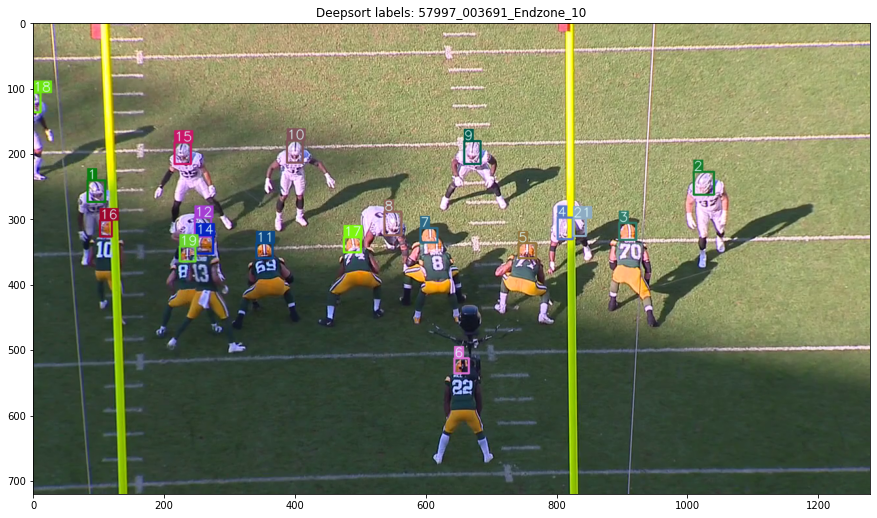

C:\Users\prena\AppData\Local\Temp/ipykernel_37300/1444635597.py:11: RuntimeWarning: overflow encountered in long_scalars
  color = [int((p * (label ** 2 - label + 1)) % 255) for p in palette]


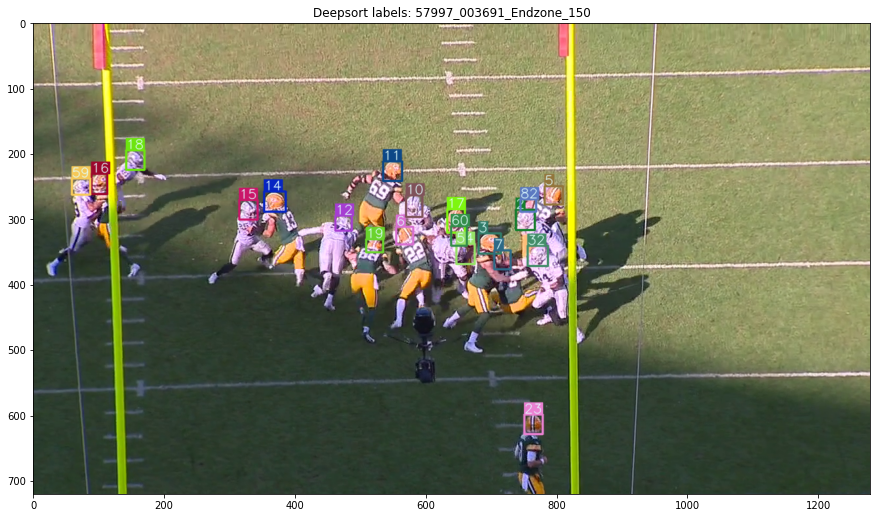

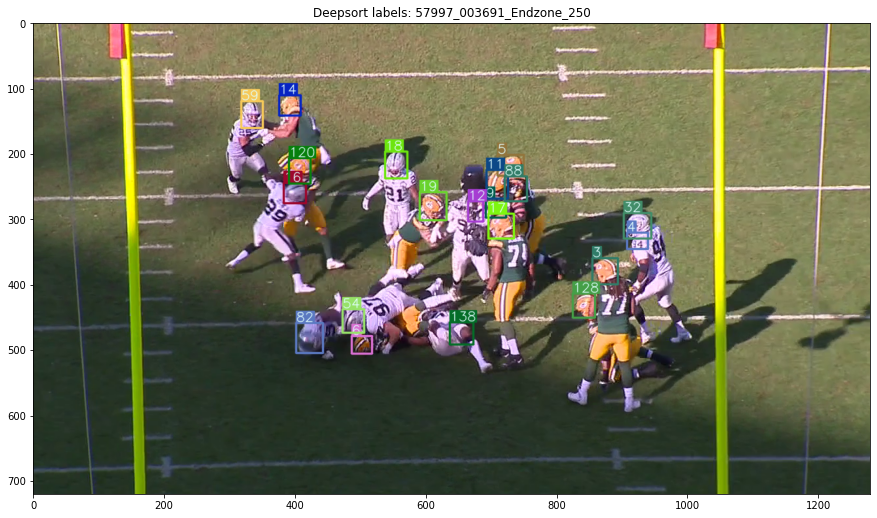

100%|██████████| 354/354 [02:10<00:00,  2.72it/s]


(6659, 13)
(5543, 13)


100%|██████████| 1/1 [02:11<00:00, 131.88s/it]

0.33539 before --> 0.69269 deepsort


In [38]:
# Add video and frame columns to submission.
submission_df['video'] = submission_df['video_frame'].str.split('_').str[:3].str.join('_')
submission_df['frame'] = submission_df['video_frame'].str.split('_').str[-1].astype('int')

if debug:
    video_dir = f'{DATA_DIR}/train/'
else:
    video_dir = f'{DATA_DIR}/test/'

# Loop through test videos and apply. If in debug mode show the score change.
out_ds = []
outs = []
for myvideo, video_data in tqdm(submission_df.groupby('video'), total=submission_df['video'].nunique()):
    print(f'==== {myvideo} ====')
    if debug:
        # Plot deepsort labels when in debug mode.
        out = deepsort_helmets(video_data, video_dir, plot_frames=[10, 150, 250])
    else:
        out = deepsort_helmets(video_data, video_dir)
    out_ds.append(out)
    out = add_deepsort_label_col(out)
    outs.append(out)
    if debug:
        # Score
        score_vs_deepsort(myvideo, out, labels)
submission_deepsort = pd.concat(outs).copy()

In [39]:
submission_df

,video_frame,left,width,top,height,label,video,frame
177159,57997_003691_Endzone_1,84,26,244,32,V29,57997_003691_Endzone,1
177152,57997_003691_Endzone_1,101,16,302,23,H10,57997_003691_Endzone,1
177164,57997_003691_Endzone_1,211,24,184,34,V25,57997_003691_Endzone,1
177153,57997_003691_Endzone_1,215,26,324,25,H13,57997_003691_Endzone,1
177150,57997_003691_Endzone_1,230,19,346,19,H88,57997_003691_Endzone,1
...,...,...,...,...,...,...,...,...
179334,57997_003691_Endzone_99,738,23,255,21,V50,57997_003691_Endzone,99
179338,57997_003691_Endzone_99,736,28,272,28,H77,57997_003691_Endzone,99
179341,57997_003691_Endzone_99,782,28,265,32,V94,57997_003691_Endzone,99
179346,57997_003691_Endzone_99,828,30,257,34,H70,57997_003691_Endzone,99
